# Homework 9: Using ML and Quantum Chemistry to model the Potential Energy Surface of a System of Atoms

In this mini-project, you will use Machine Learning to model the potential energy surface (PES) of a system with two hydrogen atoms, $H_2$. In principle, the PES of such a system is a function from $\mathbb{R}^6$ (2 nuclei with 3 coordinates each) to $\mathbb{R}$ (the energy). However, since the energy of a system of atoms is invariant to permutation of nuclei of identical atomic number, rigid-body rotation, and rigid-body translation, the system can be uniquely specified by the distance between the two nuclei. Therefore, our PES will be a function from $\mathbb{R}$ to $\mathbb{R}$, which is be easier to visualize.
The mini-project has four distinct parts:
<ul>
<li> Part 1: use Mopac to collect some data. For a set of chosen distances, use Mopac to compute the energy at that distance.
<li> Part 2: use prior knowledge to improve the ML model. In particular, you should implement the Lennard-Jones potential which will give a rough idea of the shape of PES. 
<li> Part 3: implement Kernel Ridge Regression, use it to model the PES based on the collected data.
<li> Part 4: use your ML model of the PES to predict the ground state of the system.
</ul>

In [2]:
import numpy as np
import torch
from torch.autograd import grad
import torch.nn as nn
from scipy import linalg as LA
import tqdm
from ase.calculators.mopac import MOPAC
from ase import Atoms
import matplotlib.pyplot as plt

## Part 1: Use Quantum Chemistry to Collect Data

In this part of the project, you will need to use MOPAC. You should not do optimization with MOPAC so make sure to use it with the options 'PM7 1SCF UHF'. 1SCF will ensure that you compute the energy for a given geometry of the nuclei, without trying to optimize the molecule.

**Problem 1 (1 point)**: compute the base energy (2 times energy of H atom on its own) of the $H_2$ system **in kcal/mol**, call it ae.

In [4]:
h = Atoms('H', positions=[[0, 0, 0]])
h.calc = MOPAC(label='H', task='PM7 1SCF UHF')
ae = 2 * h.get_potential_energy() * 23
print(ae)

-509.22506


**Problem 2 (1 point)**: define a function *compute_data*. Input: number of data points to collect. Output: two torch tensors, one with the distance between the nuclei, the other with the atomization energy. It is up to you to decide what range of distances you want to consider, but keep in mind that if the distance is too small, the energy will be very large, and MOPAC might fail. 

In [29]:
def compute_data(n_points):
    dist = np.linspace(.34,4,50)
    nucl_dist = []
    e_atomize = []
    while(len(nucl_dist)<n_points):
        for d in dist:
            try:
                h2 = Atoms('H2', [[0., 0., 0.], [0., 0., d]])
                h2.calc = MOPAC(label='H2', task='PM7 1SCF UHF')
                e_molecule = h2.get_potential_energy() * 23
                e_atomize.append(e_molecule)
                nucl_dist.append(d)
            except:
                continue
    return torch.FloatTensor(nucl_dist), torch.FloatTensor(e_atomize)

In [30]:
X, y = compute_data(40)

**Problem 3 (1 point)**: Define a function *plot* to plot the data. Make sure to include labels for the horizontal and vertical axis (what you measure and in what unit), a title, and a legend. For now, you can ignore the *pes* argument. It will become relevant later on when you want to plot the data and your model of the PES.  

In [31]:
def plot(X,y,pes=None):
    if pes != None:
        plt.xlim(-0.1,3)
        ml_X = np.linspace(0.02,4,200)
        plt.plot(ml_X,pes(ml_X), label='ML Model')   
    plt.plot(X,y,'.',color="red",label='MOPAC calculated data')
    plt.xlabel("Interatomic distance (Angstroms)")
    plt.ylabel("SCF energy (kcal/mol)")
    plt.title("PES of H2 calculated with MOPAC PM7")
    plt.legend() 
    plt.show()
    pass

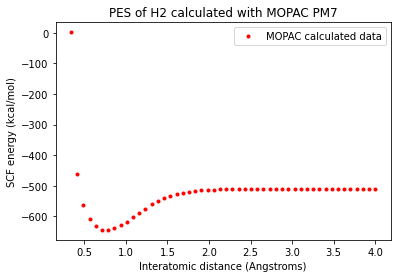

In [32]:
plot(X,y)

## Part 2: Use Force-Field to Define Prior

**Problem 4 (1 point)**: Define a force-field. Input: distance between the two nuclei. Output: energy estimate. Choose a function that roughly models how the energy varies as a function of the distance.
<ul>
<li> Energy goes to infinity as distance goes to 0
<li> Energy goes to base energy as distance goes to infinity   
</ul>

In [33]:
def FF(x):
    return ae + (1/x)

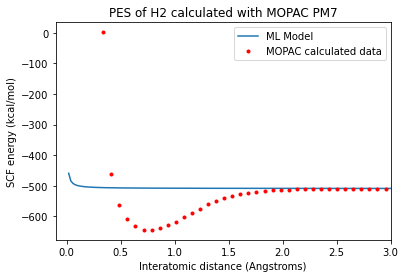

In [34]:
plot(X,y,FF)

## Part 3: Use a Gaussian Process to Refine the Prior Based on QM Data

**Problem 5 (1 point)**: define the Gaussian kernel. $l$ is the lengthscale parameter.

In [35]:
def Gaussian(l):
    return lambda X, y : np.exp((-(X-y)**2)/(2*(l**2)))

**Problem 6 (2 points)**: implement the function *solve_KRR* that uses linear algebra to compute the weights of KRR. Input:
<ul>
<li> mean: prior function
<li> kernel: kernel...
<li> X: features
<li> y: target
<li> a: regularization parameter
</ul>

In [40]:
def solve_KRR(mean,kernel,X,y,a):
    # mean?????
    n = X.shape[0]
    K = np.zeros((n,n))
    
    # Computation of K matrix
    for i in range(n):
        for j in range(n):
            K[i][j] = kernel(X[i],X[j])
            
    # Solving the linear system
    w = LA.solve(K + a * np.identity(K.shape[1]),y,assume_a='sym')
    w = torch.tensor(w, dtype=torch.float64)
    
    # The prediction function
    def f(x):
        Kv = torch.zeros(n, dtype=torch.float64)
        for i in range(n):
            Kv[i] = kernel(x,X[i])
        return Kv @ w
    return f

The following function is a utility for plotting, you will probably not need to worry about it.

In [41]:
def apply_model(model):
    
    def inner(X):
        yh = torch.zeros(len(X))
        for i in range(len(X)):
            yh[i] = model(X[i])
        return yh
    
    return inner

The following function trains a KRR model on your data using the Gaussian kernel and Lennard-Jones force-field. Input: lengthscale $l$, regulatizer $a$

In [42]:
def fit(l,a):
    model = solve_KRR(FF,Gaussian(0.16),X,y,0.000001) # l and a ?????
    pes = apply_model(model)
    plot(X,y,pes)
    return model

**Problem 7 (1 point)**: explore different values of the hyperparameters until you have a good model. You might have to try a lot of possibilities.  

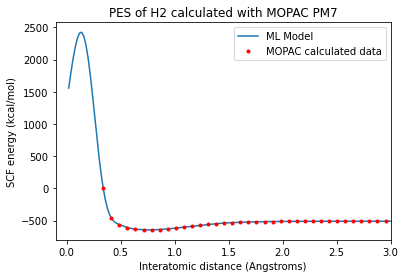

In [43]:
model = fit(0.15,0)

## Part 4: Predict Ground-State from PES Model

**Problem 8 (2 points)**: write a function *minimize* that will predict the ground state of the $H_2$ system by trying to find the global minimum of the PES (*model*). For this problem, **you will need to use automatic differentiation!**

In [14]:
def minimize(f,n_iter):
    pass

In [15]:
minimize(model,100)

0.764120623536571